## Project #4: Binary Logistic Regression

Lillian Jensen

Data Notes: This data is the same data we used for Module 5 – Linear Regression. In Module 5, we used this data to practice linear regression using hospital charges ($$) as our dependent variable. In this module we are using the same data to model in-hospital mortality (a new variable added to the database), and hospital charge data as a binary dependent variable. A list of variables, descriptions, and codes is included on D2L (Logistic Regression Codebook.doc). You will need this information while you are doing your analyses and especially while you are interpreting your results. You are being asked to look at this data to help a researcher answer two questions: 1) What patient characteristics can be used to predict death in the hospital, and 2) What characteristics can be used to predict hospital charges that might be inflated. The investigator has no idea what they mean by “inflated charges” and says to make some recommendations.

---

In [1]:
# Setting up code environment
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(comprehenr))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(rstatix))

Warning message:
"package 'comprehenr' was built under R version 4.2.3"
Warning message:
"package 'rstatix' was built under R version 4.2.3"


In [2]:
df <- read.csv("C:\\Users\\ljens\\Downloads\\HM 878 730 Clements - Logistic Regression R Data.csv")
colnames(df)

[1] "HospCharges"       "Death"             "Age"              
 [4] "Income_Zip"        "Insurance"         "Number_Diagnoses" 
 [7] "Number_Procedures" "Race"              "Sex"              
[10] "Urban_Rural"       "Weighting"

In [3]:
#######################
# Some useful functions
#######################

pred_percent <- function(mod, dep_var, name){
    prob = predict(mod, type = 'response')
    lab = ifelse(prob >= 0.5, 1, 0)
    accuracy = mean(lab == {{dep_var}}, na.rm = T)

    paste('Accuracy for ', name, ': ', round(accuracy*100,2), '%')
}

chi_log <- function(model, data, name = "model"){
    residuals <- stats::residuals(model, type = "pearson")
    pearson_chi_square <- sum(residuals^2)
    df_ <- nrow(data) - length(coefficients(model))
    p_value <- 1 - stats::pchisq(pearson_chi_square, df_)

    cat(
        "Pearson Goodness of Fit Test\n",
        "Null Hypothesis: The model fits.\n",
        "Alternative Hypothesis: The model does not fit.\n\n",
        "Pearson chi-squared for", paste0(name, ": "), round(pearson_chi_square, 2), "\n",
        "Degrees of freedom for", paste0(name, ": "), df_, "\n",
        "P-value for", paste0(name, ": "), p_value, "\n\n",
        "---\n",
        ifelse(round(p_value, 2) < 0.05, 
        "Null Hypothesis is rejected. The model does not fit.\n", 
        "Failed to reject Null Hypothesis. The model fits.\n"),
        "---"
        )
}

fences <- function(x){
    Q1 <- stats::quantile(x, 0.25)
    Q3 <- stats::quantile(x, 0.75)
    IQR_value <- stats::IQR(x)
    k <- 1.5
    lower_fence <- Q1 - k * IQR_value
    upper_fence <- Q3 + k * IQR_value

    return(
        data.frame(Lower = lower_fence, Upper = upper_fence)
    )
}

compare_models <- function(..., labels = NULL){
  if(length(labels) == 0){
    models <- list(...)
    names(models) <- unlist(lapply(
      match.call(expand.dots = FALSE)$`...`,
      function(.x) deparse(.x, width.cutoff = 500L)))
    return(models)
  }
  else{
    models <- list(...)
    names(models) <- labels
    return(models)
  }
}

---

## Regression 1 - Death

1. Use the following variables from the dataset: Dependent variable: Death.  Independent variables: Age, Income_Zip, Insurance, Number_Diagnoses, Number_Procedures, Race, Sex, and Urban_Rural.  Review the Codebook to learn more about these variables. Run a binary logistic regression analysis with Death as the Dependent Variable. Make sure to tell me how you specified which categories of your independent variables are the reference categories. Be sure to review the Codebook for the Income variable for more information, and apply this technique to the other categorical independent variables. Fully interpret your model with the appropriate information as shown in the Demo video.

In [4]:
# Factoring Income_Zip. I didn't factor the binary categorical
# variables b/c when I tried it broke my models
df$Income_Zip <- factor(df$Income_Zip, levels = c(1,2,3,4), 
                        labels = c('Q1 (lowest)', 'Q2','Q3','Q4 (highest)'))

In [5]:
mod1_0 <- glm(Death ~ 1, data = df, family = binomial)
mod1_1 <- glm(Death ~ Age  + Income_Zip  + Insurance  + Number_Diagnoses  + 
            Number_Procedures  + Race  + Sex  + Urban_Rural, 
            data=df, family = binomial, weights = Weighting
            )

In [6]:
summary(mod1_0)


Call:
glm(formula = Death ~ 1, family = binomial, data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7673  -0.7673  -0.7673   1.6532   1.6532  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.0721     0.1622  -6.609 3.88e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 227.1  on 199  degrees of freedom
Residual deviance: 227.1  on 199  degrees of freedom
AIC: 229.1

Number of Fisher Scoring iterations: 4


In [7]:
summary(mod1_1)


Call:
glm(formula = Death ~ Age + Income_Zip + Insurance + Number_Diagnoses + 
    Number_Procedures + Race + Sex + Urban_Rural, family = binomial, 
    data = df, weights = Weighting)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.473  -1.389  -1.003  -0.662   5.100  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -2.666430   0.366398  -7.277 3.40e-13 ***
Age                     0.004823   0.004218   1.143 0.252890    
Income_ZipQ2            0.485220   0.250712   1.935 0.052946 .  
Income_ZipQ3            0.940658   0.266376   3.531 0.000414 ***
Income_ZipQ4 (highest)  1.227612   0.277484   4.424 9.69e-06 ***
Insurance              -0.354570   0.195662  -1.812 0.069962 .  
Number_Diagnoses       -0.034403   0.016176  -2.127 0.033435 *  
Number_Procedures       0.065501   0.045259   1.447 0.147824    
Race                    2.074421   0.185952  11.156  < 2e-16 ***
Sex                     0.156448   0.173905  

In [8]:
pred_percent(mod1_0,df['Death'],'mod1_0')

[1] "Accuracy for  mod1_0 :  74.5 %"

In [9]:
pred_percent(mod1_1,df['Death'],'mod1_1')

[1] "Accuracy for  mod1_1 :  69.5 %"

In [10]:
chi_log(mod1_0, df, name = 'mod1_0')

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mod1_0:  200 
 Degrees of freedom for mod1_0:  199 
 P-value for mod1_0:  0.4667457 

 ---
 Failed to reject Null Hypothesis. The model fits.
 ---

In [11]:
chi_log(mod1_1, df, name = 'mod1_1')

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mod1_1:  922.71 
 Degrees of freedom for mod1_1:  189 
 P-value for mod1_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

This model produced a better AIC than the intercept model, but that was it's only improvement. 

---

2. If necessary, explain how you will revise your model to deal with outliers or multicollinearity. Rerun the model if necessary. If you don’t believe this is necessary, explain why (and yes…you can make an argument either way). For your final model, fully interpret your regression coefficients (odds ratios).

Two of our independent variables are continuous. Let's check them for outliers

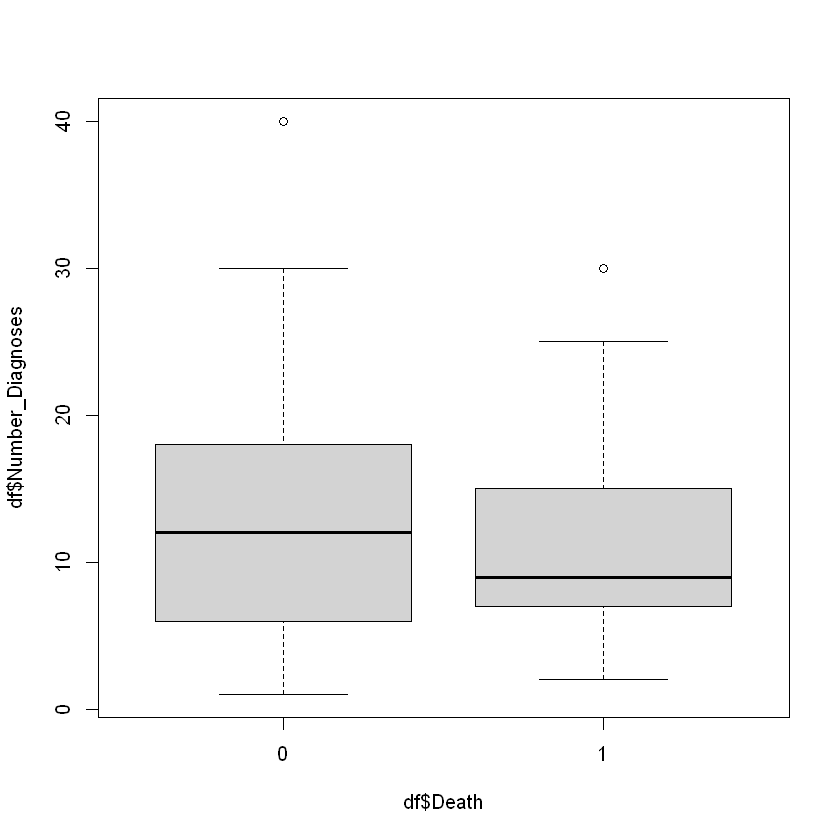

In [12]:
boxplot(df$Number_Diagnoses ~ df$Death)

In [13]:
fences(df$Number_Diagnoses)$Upper

[1] 32.375

In [14]:
df[df$Number_Diagnoses >= fences(df$Number_Diagnoses)$Upper,]$Death

[1] 0 0

There are two outliers in Number_Diagnoses, and both belong to the 'alive' category. This seems like meaningful information for our model, so I will leave these outliers in.

Now let's check for outliers in Number_Diagnoses

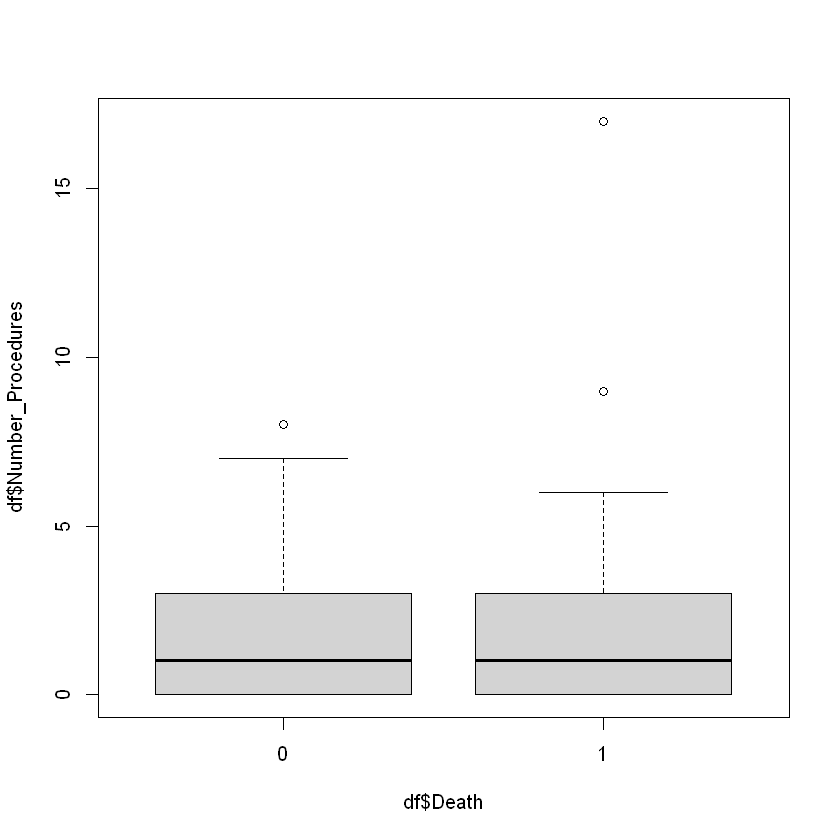

In [15]:
boxplot(df$Number_Procedures ~ df$Death)

In [16]:
fences(df$Number_Procedures)$Upper

[1] 7.5

In [17]:
df[df$Number_Procedures >= fences(df$Number_Procedures)$Upper,]$Death

[1] 1 0 1 0

There are four outliers in Number_Procedures, and they are evenly split between the 'alive' and 'dead' categories, possibly causing noise in the data. We should consider cutting these outliers.

Before we do, however, let's take a look at multicollinearity

In [18]:
ind_vars <- c(
            'Age','Income_Zip','Insurance','Number_Diagnoses',
            'Number_Procedures','Race','Sex','Urban_Rural'
                )

In [19]:
df <- read.csv("C:\\Users\\ljens\\Downloads\\HM 878 730 Clements - Logistic Regression R Data.csv")
colnames(df)

[1] "HospCharges"       "Death"             "Age"              
 [4] "Income_Zip"        "Insurance"         "Number_Diagnoses" 
 [7] "Number_Procedures" "Race"              "Sex"              
[10] "Urban_Rural"       "Weighting"

In [20]:
ind_df <- df |> select(all_of(ind_vars))

In [21]:
print(cor_mat(ind_df, method = 'spearman'))

# A tibble: 8 × 9
  rowname             Age Incom…¹ Insur…² Numbe…³ Numbe…⁴    Race    Sex Urban…⁵
* <chr>             <dbl>   <dbl>   <dbl>   <dbl>   <dbl>   <dbl>  <dbl>   <dbl>
1 Age              1       0.12   -3.8e-1  0.57    -0.19  -2.7e-1 -0.12  -0.0059
2 Income_Zip       0.12    1       1  e-1 -0.0064  -0.036 -6.1e-2  0.062 -0.34  
3 Insurance       -0.38    0.1     1  e+0 -0.44     0.056  4.5e-4  0.039 -0.0056
4 Number_Diagnos…  0.57   -0.0064 -4.4e-1  1        0.023 -1.4e-1 -0.048 -0.007 
5 Number_Procedu… -0.19   -0.036   5.6e-2  0.023    1      3.2e-2  0.055 -0.14  
6 Race            -0.27   -0.061   4.5e-4 -0.14     0.032  1  e+0  0.1   -0.17  
7 Sex             -0.12    0.062   3.9e-2 -0.048    0.055  1  e-1  1     -0.032 
8 Urban_Rural     -0.0059 -0.34   -5.6e-3 -0.007   -0.14  -1.7e-1 -0.032  1     
# … with abbreviated variable names ¹​Income_Zip, ²​Insurance, ³​Number_Diagnoses,
#   ⁴​Number_Procedures, ⁵​Urban_Rural


In [22]:
print(cor_get_pval(cor_mat(ind_df, method = 'spearman')))

# A tibble: 8 × 9
  rowname           Age Incom…¹ Insura…² Number…³ Numbe…⁴    Race    Sex Urban…⁵
  <chr>           <dbl>   <dbl>    <dbl>    <dbl>   <dbl>   <dbl>  <dbl>   <dbl>
1 Age          0        9.01e-2 2.43e- 8 6.01e-19 0.00676 1.34e-4 0.0952 9.34e-1
2 Income_Zip   9.01e- 2 0       1.54e- 1 9.29e- 1 0.616   4.03e-1 0.39   1.06e-6
3 Insurance    2.43e- 8 1.54e-1 0        1.12e-10 0.434   9.95e-1 0.588  9.38e-1
4 Number_Diag… 6.01e-19 9.29e-1 1.12e-10 0        0.744   4.51e-2 0.503  9.21e-1
5 Number_Proc… 6.76e- 3 6.16e-1 4.34e- 1 7.44e- 1 0       6.55e-1 0.442  5.54e-2
6 Race         1.34e- 4 4.03e-1 9.95e- 1 4.51e- 2 0.655   0       0.142  1.43e-2
7 Sex          9.52e- 2 3.9 e-1 5.88e- 1 5.03e- 1 0.442   1.42e-1 0      6.53e-1
8 Urban_Rural  9.34e- 1 1.06e-6 9.38e- 1 9.21e- 1 0.0554  1.43e-2 0.653  0      
# … with abbreviated variable names ¹​Income_Zip, ²​Insurance, ³​Number_Diagnoses,
#   ⁴​Number_Procedures, ⁵​Urban_Rural


Age and Number_Diagnoses are the only two variables with significantly large (>0.50) collinearities. As we saw in the last worksheet, it is best to retain both of those variables because they both contribute to the model.

Let's try building a model with the Number_Prodecures outliers removed.

In [23]:
df$Income_Zip <- factor(df$Income_Zip, levels = c(1,2,3,4), labels = c('Q1 (lowest)', 'Q2','Q3','Q4 (highest)'))
df <- df[df$Number_Procedures < fences(df$Number_Procedures)$Upper,]

In [24]:
mod2_0 <- glm(Death ~ 1, data = df, family = binomial, weights = Weighting)
mod2_1 <- glm(Death ~ Age  + Income_Zip  + Insurance  + Number_Diagnoses  + 
            Number_Procedures  + Race  + Sex  + Urban_Rural, 
            data=df, family = binomial, weights = Weighting
            )


summary(mod2_0)
summary(mod2_1)

pred_percent(mod2_0,df['Death'],'mod2_0')
pred_percent(mod2_1,df['Death'],'mod2_1')


chi_log(mod2_0, df, name = 'mod2_0')
print('')
chi_log(mod2_1, df, name = 'mod2_1')



Call:
glm(formula = Death ~ 1, family = binomial, data = df, weights = Weighting)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6961  -1.6961  -1.6961  -0.3411   3.7234  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.09861    0.07377  -14.89   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1102.2  on 195  degrees of freedom
Residual deviance: 1102.2  on 195  degrees of freedom
AIC: 1104.2

Number of Fisher Scoring iterations: 5



Call:
glm(formula = Death ~ Age + Income_Zip + Insurance + Number_Diagnoses + 
    Number_Procedures + Race + Sex + Urban_Rural, family = binomial, 
    data = df, weights = Weighting)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.454  -1.420  -1.007  -0.645   5.162  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -2.728206   0.375771  -7.260 3.86e-13 ***
Age                     0.004502   0.004258   1.057   0.2904    
Income_ZipQ2            0.566398   0.258134   2.194   0.0282 *  
Income_ZipQ3            1.078709   0.272757   3.955 7.66e-05 ***
Income_ZipQ4 (highest)  1.259957   0.281020   4.484 7.34e-06 ***
Insurance              -0.288545   0.196359  -1.469   0.1417    
Number_Diagnoses       -0.035027   0.016438  -2.131   0.0331 *  
Number_Procedures       0.056507   0.052453   1.077   0.2814    
Race                    2.045714   0.189015  10.823  < 2e-16 ***
Sex                     0.248641   0.177052  

[1] "Accuracy for  mod2_0 :  75 %"

[1] "Accuracy for  mod2_1 :  69.9 %"

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mod2_0:  980 
 Degrees of freedom for mod2_0:  195 
 P-value for mod2_0:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---[1] ""
Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mod2_1:  902.37 
 Degrees of freedom for mod2_1:  185 
 P-value for mod2_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

In [25]:
pred_percent(mod1_1, df$Death, "mod1_1")
pred_percent(mod2_1, df$Death, "mod2_1")
compare_models(mod1_1,mod2_1)

Warning message in lab == {:
"longer object length is not a multiple of shorter object length"


[1] "Accuracy for  mod1_1 :  68.37 %"

Warning message in lab == {:
"longer object length is not a multiple of shorter object length"


[1] "Accuracy for  mod2_1 :  69.9 %"

$mod1_1

Call:  glm(formula = Death ~ Age + Income_Zip + Insurance + Number_Diagnoses + 
    Number_Procedures + Race + Sex + Urban_Rural, family = binomial, 
    data = df, weights = Weighting)

Coefficients:
           (Intercept)                     Age            Income_ZipQ2  
             -2.666430                0.004823                0.485220  
          Income_ZipQ3  Income_ZipQ4 (highest)               Insurance  
              0.940658                1.227612               -0.354570  
      Number_Diagnoses       Number_Procedures                    Race  
             -0.034403                0.065501                2.074421  
                   Sex             Urban_Rural  
              0.156448                0.154577  

Degrees of Freedom: 191 Total (i.e. Null);  181 Residual
  (8 observations deleted due to missingness)
Null Deviance:	    1069 
Residual Deviance: 883.7 	AIC: 905.7

$mod2_1

Call:  glm(formula = Death ~ Age + Income_Zip + Insurance + Number_Diagnoses +

No improvement after removing outliers.

In [26]:
################
# In this cell I toyed with variables Age and Number_Procedures, due to 
# high correlations between the two. Removing Age produced a slightly better
# model
################

mod3_0 <- glm(Death ~ 1, family = binomial, data = df)
mod3_1 <- glm(
    Death ~ 
    #Age + 
    Income_Zip +
    Insurance + 
    Number_Diagnoses + 
    Number_Procedures + 
    Race +
    Sex  +
    Urban_Rural
    , family = binomial, 
    data = df, weights = Weighting
    )

summary(mod3_0)
summary(mod3_1)
pred_percent(mod3_0, df$Death, "mod3_0")
pred_percent(mod3_1, df$Death, "mod3_1")

chi_log(mod3_1, df, 'mod3_1')


Call:
glm(formula = Death ~ 1, family = binomial, data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7585  -0.7585  -0.7585  -0.1526   1.6651  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.099      0.165   -6.66 2.74e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 220.44  on 195  degrees of freedom
Residual deviance: 220.44  on 195  degrees of freedom
AIC: 222.44

Number of Fisher Scoring iterations: 4



Call:
glm(formula = Death ~ Income_Zip + Insurance + Number_Diagnoses + 
    Number_Procedures + Race + Sex + Urban_Rural, family = binomial, 
    data = df, weights = Weighting)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3894  -1.4011  -1.0159  -0.6515   5.1259  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -2.56699    0.34026  -7.544 4.55e-14 ***
Income_ZipQ2            0.57214    0.25766   2.220   0.0264 *  
Income_ZipQ3            1.11948    0.27058   4.137 3.51e-05 ***
Income_ZipQ4 (highest)  1.27879    0.28088   4.553 5.29e-06 ***
Insurance              -0.31387    0.19503  -1.609   0.1075    
Number_Diagnoses       -0.02572    0.01373  -1.873   0.0610 .  
Number_Procedures       0.04277    0.05091   0.840   0.4009    
Race                    1.99413    0.18143  10.991  < 2e-16 ***
Sex                     0.24189    0.17687   1.368   0.1714    
Urban_Rural            -0.05619    0.29498  -0.190 

[1] "Accuracy for  mod3_0 :  75 %"

Warning message in lab == {:
"longer object length is not a multiple of shorter object length"


[1] "Accuracy for  mod3_1 :  68.88 %"

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mod3_1:  896.18 
 Degrees of freedom for mod3_1:  186 
 P-value for mod3_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

In [27]:
compare_models(mod1_1, mod3_1)

$mod1_1

Call:  glm(formula = Death ~ Age + Income_Zip + Insurance + Number_Diagnoses + 
    Number_Procedures + Race + Sex + Urban_Rural, family = binomial, 
    data = df, weights = Weighting)

Coefficients:
           (Intercept)                     Age            Income_ZipQ2  
             -2.666430                0.004823                0.485220  
          Income_ZipQ3  Income_ZipQ4 (highest)               Insurance  
              0.940658                1.227612               -0.354570  
      Number_Diagnoses       Number_Procedures                    Race  
             -0.034403                0.065501                2.074421  
                   Sex             Urban_Rural  
              0.156448                0.154577  

Degrees of Freedom: 191 Total (i.e. Null);  181 Residual
  (8 observations deleted due to missingness)
Null Deviance:	    1069 
Residual Deviance: 883.7 	AIC: 905.7

$mod3_1

Call:  glm(formula = Death ~ Income_Zip + Insurance + Number_Diagnoses + 
    

In [28]:
pred_percent(mod1_1, df$Death, 'mod1_1')
pred_percent(mod2_1, df$Death, 'mod2_1')
pred_percent(mod3_1, df$Death, 'mod3_1')

Warning message in lab == {:
"longer object length is not a multiple of shorter object length"


[1] "Accuracy for  mod1_1 :  68.37 %"

Warning message in lab == {:
"longer object length is not a multiple of shorter object length"


[1] "Accuracy for  mod2_1 :  69.9 %"

Warning message in lab == {:
"longer object length is not a multiple of shorter object length"


[1] "Accuracy for  mod3_1 :  68.88 %"

The third model, with Age removed, had a slightly improved AIC but lower accuracy. TBH I don't feel great about either model because they both have lower accuracy than the intercept-only model.

**Odds Ratios**

In [29]:
data.frame(
    Odds_Ratio = exp(coef(mod3_1)), 
    CI_Lower = exp(confint(mod3_1))[,1], 
    CI_Upper = exp(confint(mod3_1))[,2]
    )

Waiting for profiling to be done...

Waiting for profiling to be done...



,Odds_Ratio,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>
(Intercept),0.07676646,0.03885365,0.1476473
Income_ZipQ2,1.77204637,1.07521136,2.9582282
Income_ZipQ3,3.06326921,1.81411674,5.2493550
Income_ZipQ4 (highest),3.59229773,2.08698087,6.2869425
Insurance,0.73061166,0.49681239,1.0680427
Number_Diagnoses,0.97461044,0.94839591,1.0008916
Number_Procedures,1.04369670,0.94341022,1.1521124
Race,7.34577601,5.17246576,10.5412896
Sex,1.27364906,0.90079508,1.8033964


In [30]:
data.frame(
    Odds_Ratio = exp(coef(mod1_1)), 
    CI_Lower = exp(confint(mod1_1))[,1], 
    CI_Upper = exp(confint(mod1_1))[,2]
    )

Waiting for profiling to be done...

Waiting for profiling to be done...



,Odds_Ratio,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>
(Intercept),0.06949993,0.03333471,0.1403969
Age,1.00483437,0.99662433,1.0132589
Income_ZipQ2,1.62453216,0.99782507,2.6707728
Income_ZipQ3,2.56166597,1.52779362,4.3478012
Income_ZipQ4 (highest),3.41307043,1.99470152,5.9290407
Insurance,0.70147518,0.47635278,1.0265977
Number_Diagnoses,0.96618181,0.93550322,0.9967807
Number_Procedures,1.06769369,0.97636455,1.1663940
Race,7.95993645,5.55961756,11.5338749


I will interpret the Odds-Ratios for the first model, which was the least awful model of the three I tried.

We can see with the confidence intervals that the odds-ratios for the following ind. variables are insignificant: Age, Insurance, Number_Procedures, Sex, and Urban_Rural. We have significant odds-ratios for the rest:

- As income increased, so did the risk of death, with the second quartile being 76% more likely to die, the third q being 194% more likely, and the fourth q (highest income) being 253% more likely to die.

- Each unit of increase in Number_Diagnoses was associated with 4% decrease in odds of death.

- Having non-white race was associated with 673% higher odds of death. 

- Living in a rural area was associated with 6% lower odds of death.

**Overall Impression**

The significantly higher risk of death for non-white race is consistent with what we already understand about health disparities for people of color. That said, I don't feel great about this model due to low accuracy, high AIC, and poor fit. I would not consider the results reliable.

---

## Regression 2 - Hospital Charges

1. Hospital charges is currently a continuous, quantitative variable. You need to create a new variable that is a binary, categorical variable with a cutoff at a certain dollar amount that separates high costs from low costs. You can use any cutoff you want, but you must justify your choice of cutoff (e.g. use some of the descriptive statistics to propose a cutoff, or use some research literature to justify how you determine the cutoff). Run a logistic regression with your newly created variable as the dependent variable and Age, Income_Zip, Insurance, Number_Diagnoses, Number_Procedures, Race, Sex, and Urban_Rural as the independent variables. Fully interpret your initial model (again, being sure to explain your independent variable reference categories).

2. Now that you have run this regression model, evaluate whether your model needs to be revised. Pay attention to outliers, and multicollinearity (and for these purposes, you might consider moderate correlation as suggestive of multicollinearity). In addition, you should consider whether your cutoff to develop your categorical dependent variable should be revised at all. Run as many regression models as you need to based on these revisions. Fully explain why you are making the choices you make. Note: Most analyses like these are all about decision-making. There are tradeoffs in all of the models and with the decisions you make. Justify your choices.


For this problem I experimented with a few HospCharges cutoffs to see if I could find a useful model. You will see below that I placed each cutoff model into a single cell in this notebook, then iteratively experimented with removing various variables from each model to try to find its respectively best-performing version. Performance was determined by the model's accuracy, AIC, and fit compared to the intercept-only model.  

I used the ind. var correlation matrix to guide my choices about which variables to remove. I also looked at the change in model accuracy that each variable had. In some cases, I chose to remove variables with no collinearities if/when accuracy was greatly improved. Oftentimes removing Race improved model accuracy, however, not without a trade-off of a significantly increased AIC.

The format of this notebook allows me to run, tweak, and re-run cells with ease, so not every attempted model is shown here. Rather, the final and best-performing versions of the models are what you see below:

In [31]:
# Setting cutoff to HospCharges Upper Fence

cut <- round(
    fences(df$HospCharges)$Upper # Upper Fence
    ,0)

df$charges <- ifelse(df$HospCharges<cut, 0, 1)

paste('HospCharges cutoff: ',cut)

u_fence_0 <- glm(charges ~ 1, data = df, family = binomial)
u_fence_1 <- glm(charges ~ 
            Age  + 
            Income_Zip  + 
            #Insurance  + 
            #Number_Diagnoses  + 
            #Number_Procedures  + 
            Race  + 
            Sex  + 
            Urban_Rural
            , 
            data=df, family = binomial, weights = Weighting
            )

pred_percent(u_fence_0,df['charges'],'u_fence_0')
pred_percent(u_fence_1,df['charges'],'u_fence_1')

summary(u_fence_0)
summary(u_fence_1)


chi_log(u_fence_0, df, name = 'u_fence_0')
paste('')
chi_log(u_fence_1, df, name = 'u_fence_1')



[1] "HospCharges cutoff:  113280"

[1] "Accuracy for  u_fence_0 :  91.33 %"

[1] "Accuracy for  u_fence_1 :  91.33 %"


Call:
glm(formula = charges ~ 1, family = binomial, data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.426  -0.426  -0.426  -0.426   2.211  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.3542     0.2538  -9.276   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 115.61  on 195  degrees of freedom
Residual deviance: 115.61  on 195  degrees of freedom
AIC: 117.61

Number of Fisher Scoring iterations: 5



Call:
glm(formula = charges ~ Age + Income_Zip + Race + Sex + Urban_Rural, 
    family = binomial, data = df, weights = Weighting)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5608  -1.1195  -0.8026  -0.0003   5.4395  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.388755   0.581907  -5.824 5.76e-09 ***
Age                      0.008196   0.005150   1.592  0.11147    
Income_ZipQ2             1.387752   0.494194   2.808  0.00498 ** 
Income_ZipQ3             1.263436   0.512499   2.465  0.01369 *  
Income_ZipQ4 (highest)   0.652667   0.535067   1.220  0.22255    
Race                    -0.044355   0.277054  -0.160  0.87281    
Sex                     -0.538223   0.252293  -2.133  0.03290 *  
Urban_Rural            -17.128174 765.293603  -0.022  0.98214    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for u_fence_0:  196 
 Degrees of freedom for u_fence_0:  195 
 P-value for u_fence_0:  0.4664079 

 ---
 Failed to reject Null Hypothesis. The model fits.
 ---

[1] ""

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for u_fence_1:  744.36 
 Degrees of freedom for u_fence_1:  188 
 P-value for u_fence_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

In [32]:
# Setting cutoff to HospCharges mean + 1 standard deviation

cut <- round(
    sd(df$HospCharges) + mean(df$HospCharges) # Mean + 1 Standard Deviation
    ,0)

df$charges <- ifelse(df$HospCharges<cut, 0, 1)
paste('HospCharges cutoff: ',cut)

mean_sd_0 <- glm(charges ~ 1, data = df, family = binomial)
mean_sd_1 <- glm(charges ~ 
            Age  + 
            #Income_Zip  + 
            Insurance  + 
            Number_Diagnoses  + 
            Number_Procedures  + 
            #Race  + 
            Sex  + 
            Urban_Rural
            , 
            data=df, family = binomial, weights = Weighting
            )

pred_percent(mean_sd_0,df['charges'],'mean_sd_0')
pred_percent(mean_sd_1,df['charges'],'mean_sd_1')

summary(mean_sd_0)
summary(mean_sd_1)


chi_log(mean_sd_0, df, name = 'mean_sd_0')
paste('')
chi_log(mean_sd_1, df, name = 'mean_sd_1')



[1] "HospCharges cutoff:  98102"

[1] "Accuracy for  mean_sd_0 :  91.33 %"

[1] "Accuracy for  mean_sd_1 :  92.86 %"


Call:
glm(formula = charges ~ 1, family = binomial, data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.426  -0.426  -0.426  -0.426   2.211  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.3542     0.2538  -9.276   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 115.61  on 195  degrees of freedom
Residual deviance: 115.61  on 195  degrees of freedom
AIC: 117.61

Number of Fisher Scoring iterations: 5



Call:
glm(formula = charges ~ Age + Insurance + Number_Diagnoses + 
    Number_Procedures + Sex + Urban_Rural, family = binomial, 
    data = df, weights = Weighting)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0392  -0.8451  -0.5405  -0.2966   5.7195  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -5.732659   0.635755  -9.017  < 2e-16 ***
Age                0.010397   0.007288   1.427  0.15368    
Insurance          0.919989   0.305393   3.012  0.00259 ** 
Number_Diagnoses   0.111670   0.021111   5.290 1.23e-07 ***
Number_Procedures  0.603316   0.069836   8.639  < 2e-16 ***
Sex               -0.771440   0.277132  -2.784  0.00537 ** 
Urban_Rural       -1.197695   0.499050  -2.400  0.01640 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 577.13  on 194  degrees of freedom
Residual deviance: 422.77  on 188  degrees 

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mean_sd_0:  196 
 Degrees of freedom for mean_sd_0:  195 
 P-value for mean_sd_0:  0.4664079 

 ---
 Failed to reject Null Hypothesis. The model fits.
 ---

[1] ""

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mean_sd_1:  734.46 
 Degrees of freedom for mean_sd_1:  189 
 P-value for mean_sd_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

In [33]:
# Setting cutoff to 75,000

cut <- round(
    75000     # Hand-picked Cutoff
    ,0)

df$charges <- ifelse(df$HospCharges<cut, 0, 1)

paste('HospCharges cutoff: ',cut)

hp_0 <- glm(charges ~ 1, data = df, family = binomial)
hp_1 <- glm(charges ~ 
            Age  + 
            Income_Zip  + 
            Insurance  + 
            #Number_Diagnoses  + 
            Number_Procedures  + 
            #Race  + 
            Sex   
            #Urban_Rural
            , 
            data=df, family = binomial, weights = Weighting
            )

pred_percent(hp_0,df['charges'],'hp_0')
pred_percent(hp_1,df['charges'],'hp_1')

summary(hp_0)
summary(hp_1)


chi_log(hp_0, df, name = 'hp_0')
paste('')

chi_log(hp_1, df, name = 'hp_1')



[1] "HospCharges cutoff:  75000"

[1] "Accuracy for  hp_0 :  84.18 %"

[1] "Accuracy for  hp_1 :  86.73 %"


Call:
glm(formula = charges ~ 1, family = binomial, data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5868  -0.5868  -0.5868  -0.5868   1.9205  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6720     0.1957  -8.541   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 171.15  on 195  degrees of freedom
Residual deviance: 171.15  on 195  degrees of freedom
AIC: 173.15

Number of Fisher Scoring iterations: 3



Call:
glm(formula = charges ~ Age + Income_Zip + Insurance + Number_Procedures + 
    Sex, family = binomial, data = df, weights = Weighting)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0561  -1.1288  -0.7921  -0.4177   5.7049  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -5.157754   0.512317 -10.068  < 2e-16 ***
Age                     0.022073   0.005012   4.404 1.06e-05 ***
Income_ZipQ2            1.840618   0.377572   4.875 1.09e-06 ***
Income_ZipQ3            1.097113   0.411164   2.668  0.00762 ** 
Income_ZipQ4 (highest)  1.327714   0.412467   3.219  0.00129 ** 
Insurance              -0.188857   0.239288  -0.789  0.42997    
Number_Procedures       0.618492   0.057358  10.783  < 2e-16 ***
Sex                    -0.526690   0.216666  -2.431  0.01506 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for hp_0:  196 
 Degrees of freedom for hp_0:  195 
 P-value for hp_0:  0.4664079 

 ---
 Failed to reject Null Hypothesis. The model fits.
 ---

[1] ""

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for hp_1:  847.29 
 Degrees of freedom for hp_1:  188 
 P-value for hp_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

In [34]:
# Setting cutoff to 3rd Q.

cut <- round(
    summary(df$HospCharges)[[5]] # 75th percentile
    ,0)

df$charges <- ifelse(df$HospCharges<cut, 0, 1)
paste('HospCharges cutoff: ',cut)


q3_0 <- glm(charges ~ 1, data = df, family = binomial)
q3_1 <- glm(charges ~ 
            Age  + 
            #Income_Zip  + 
            Insurance  + 
            Number_Diagnoses  + 
            Number_Procedures  + 
            #Race  + 
            Sex  + 
            Urban_Rural
            , 
            data=df, family = binomial, weights = Weighting
            )

pred_percent(q3_0,df['charges'],'q3_0')
pred_percent(q3_1,df['charges'],'q3_1')

summary(q3_0)
summary(q3_1)


chi_log(q3_0, df, name = 'q3_0')
paste('')

chi_log(q3_1, df, name = 'q3_1')




[1] "HospCharges cutoff:  53585"

[1] "Accuracy for  q3_0 :  75 %"

[1] "Accuracy for  q3_1 :  79.59 %"


Call:
glm(formula = charges ~ 1, family = binomial, data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7585  -0.7585  -0.7585  -0.1526   1.6651  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -1.099      0.165   -6.66 2.74e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 220.44  on 195  degrees of freedom
Residual deviance: 220.44  on 195  degrees of freedom
AIC: 222.44

Number of Fisher Scoring iterations: 4



Call:
glm(formula = charges ~ Age + Insurance + Number_Diagnoses + 
    Number_Procedures + Sex + Urban_Rural, family = binomial, 
    data = df, weights = Weighting)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-4.935  -1.452  -1.040  -0.397   5.172  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -4.448931   0.392903 -11.323  < 2e-16 ***
Age                0.022870   0.004547   5.029 4.92e-07 ***
Insurance          0.644630   0.207201   3.111  0.00186 ** 
Number_Diagnoses   0.074713   0.014473   5.162 2.44e-07 ***
Number_Procedures  0.567181   0.051452  11.024  < 2e-16 ***
Sex               -0.447618   0.173706  -2.577  0.00997 ** 
Urban_Rural        0.253327   0.232175   1.091  0.27523    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1088.23  on 194  degrees of freedom
Residual deviance:  860.34  on 188  degrees of freed

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for q3_0:  196 
 Degrees of freedom for q3_0:  195 
 P-value for q3_0:  0.4664079 

 ---
 Failed to reject Null Hypothesis. The model fits.
 ---

[1] ""

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for q3_1:  928.99 
 Degrees of freedom for q3_1:  189 
 P-value for q3_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

In [35]:
# Setting cutoff to HospCharges mean

cut <- round(
    summary(df$HospCharges)[[4]] # Mean
    ,0)

df$charges <- ifelse(df$HospCharges<=cut, 0, 1)
paste('HospCharges cutoff: ',cut)


mean_cut_0 <- glm(charges ~ 1, data = df, family = binomial)
mean_cut_1 <- glm(charges ~ 
            Age  + 
            #Income_Zip  + 
            Insurance  + 
            #Number_Diagnoses  + 
            Number_Procedures  + 
            #Race  + 
            Sex  + 
            Urban_Rural
            , 
            data=df, family = binomial, weights = Weighting
            )

pred_percent(mean_cut_0,df['charges'],'mean_cut_0')
pred_percent(mean_cut_1,df['charges'],'mean_cut_1')

summary(mean_cut_0)
summary(mean_cut_1)


chi_log(mean_cut_0, df, name = 'mean_cut_0')
paste('')

chi_log(mean_cut_1, df, name = 'mean_cut_1')



[1] "HospCharges cutoff:  44774"

[1] "Accuracy for  mean_cut_0 :  68.37 %"

[1] "Accuracy for  mean_cut_1 :  75.51 %"


Call:
glm(formula = charges ~ 1, family = binomial, data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8721  -0.8721  -0.8721   1.5172   1.5172  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.7707     0.1536  -5.018 5.23e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 244.64  on 195  degrees of freedom
Residual deviance: 244.64  on 195  degrees of freedom
AIC: 246.64

Number of Fisher Scoring iterations: 4



Call:
glm(formula = charges ~ Age + Insurance + Number_Procedures + 
    Sex + Urban_Rural, family = binomial, data = df, weights = Weighting)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-4.508  -1.683  -1.154   1.963   4.724  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -3.387035   0.320203 -10.578   <2e-16 ***
Age                0.032438   0.003832   8.464   <2e-16 ***
Insurance          0.008891   0.179936   0.049   0.9606    
Number_Procedures  0.569221   0.049908  11.405   <2e-16 ***
Sex               -0.325909   0.159679  -2.041   0.0412 *  
Urban_Rural       -0.027445   0.217315  -0.126   0.8995    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1211.61  on 194  degrees of freedom
Residual deviance:  983.77  on 189  degrees of freedom
  (1 observation deleted due to missingness)
AIC: 995.77

Number of Fisher Scorin

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mean_cut_0:  196 
 Degrees of freedom for mean_cut_0:  195 
 P-value for mean_cut_0:  0.4664079 

 ---
 Failed to reject Null Hypothesis. The model fits.
 ---

[1] ""

Pearson Goodness of Fit Test
 Null Hypothesis: The model fits.
 Alternative Hypothesis: The model does not fit.

 Pearson chi-squared for mean_cut_1:  924.4 
 Degrees of freedom for mean_cut_1:  190 
 P-value for mean_cut_1:  0 

 ---
 Null Hypothesis is rejected. The model does not fit.
 ---

In [36]:
compare_models(u_fence_0 ,u_fence_1 ,
mean_sd_0,mean_sd_1,
hp_0,hp_1,
q3_0,q3_1,
mean_cut_0,mean_cut_1)

$u_fence_0

Call:  glm(formula = charges ~ 1, family = binomial, data = df)

Coefficients:
(Intercept)  
     -2.354  

Degrees of Freedom: 195 Total (i.e. Null);  195 Residual
Null Deviance:	    115.6 
Residual Deviance: 115.6 	AIC: 117.6

$u_fence_1

Call:  glm(formula = charges ~ Age + Income_Zip + Race + Sex + Urban_Rural, 
    family = binomial, data = df, weights = Weighting)

Coefficients:
           (Intercept)                     Age            Income_ZipQ2  
             -3.388755                0.008196                1.387752  
          Income_ZipQ3  Income_ZipQ4 (highest)                    Race  
              1.263436                0.652667               -0.044355  
                   Sex             Urban_Rural  
             -0.538223              -17.128174  

Degrees of Freedom: 189 Total (i.e. Null);  182 Residual
  (6 observations deleted due to missingness)
Null Deviance:	    549 
Residual Deviance: 492 	AIC: 508

$mean_sd_0

Call:  glm(formula = charges ~ 1, fa

Accuracy for  u_fence_0 :  91.33 %

Accuracy for  u_fence_1 :  91.33 %

Accuracy for  mean_sd_0 :  91.33 %

Accuracy for  mean_sd_1 :  92.86 %

Accuracy for  hp_0 :  84.18 %

Accuracy for  hp_1 :  86.73 %

Accuracy for  q3_0 :  75 %

Accuracy for  q3_1 :  79.59 %

Accuracy for  mean_cut_0 :  68.37 %

Accuracy for  mean_cut_1 :  75.51 %

---

3. Choose one model as your best fit model, interpret the findings and describe what the regression coefficients (odds ratios) mean.

The cutoffs that I tried ranged from the HospCharges mean to the HospCharges upper fence, with a slightly different interpretation for each. For the higher cutoffs, it would be something like "what are the factors that lead to an individual having exceptionally high hospital charges?" For cutoffs at or around the mean, the question is "what are the factors that lead to an individual having higher-than-average hospital charges?"

I wanted to choose the model that was the most meaningful. The upper-fence cutoff and the mean+sd cutoff models both had high accuracies that didn't differ much from the intercept-only models. This made sense because there were only around 17 individuals with such high charges; the intercept could easily account for this.

In contrast, models with lower cutoffs had higher increases in accuracy, with the mean cutoff model improving the most at 7%. While the improvement is exciting, it should be taken with a grain of salt. The mean cutoff model's AIC increased from 247 in the intercept model to 996 in the variable model. Moreover, this model was not a good fit. 

Each model had significant flaws, and I wouldn't consider any of them reliable. I will choose the mean cutoff model as the best fit for our purposes due to the increase in accuracy, but I want to include a disclaimer that none of the models should be considered good-fits.

In [37]:
data.frame(
    Odds_Ratio = exp(coef(mean_cut_1)), 
    CI_Lower = exp(confint(mean_cut_1))[,1], 
    CI_Upper = exp(confint(mean_cut_1))[,2]
    )

Waiting for profiling to be done...

Waiting for profiling to be done...



,Odds_Ratio,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>
(Intercept),0.03380878,0.01763482,0.06197244
Age,1.03296968,1.02546345,1.04100397
Insurance,1.00893106,0.70852834,1.43565656
Number_Procedures,1.76689062,1.60556913,1.95291751
Sex,0.72187092,0.52748658,0.98693577
Urban_Rural,0.97292798,0.63127726,1.48207874


The odds ratios that are considered significant according to their confidence intervals were:

- Age. Each unit increase in age increased the odds of higher-than-average charges by 3%

- Number_Procedures. Each additional procedure increased odds of higher-than-average charges by 77%

- Sex. Being female reduced odds of higher-than-average charges by 28%

- Urban_Rural. Living in a rural area reduced odds of higher-than-average charges by 3%

---

## Answer this question:

- When you did a linear regression model in Module 5, you used hospital charges as a continuous dependent variable, and here you used a categorical version of that same variable. How are the results of the two models similar and how do they differ? Describe different situations when you would use each of the models.

In [38]:
mod6 <- lm(log(HospCharges) ~ 
    Age + 
    #Income_Zip + 
    Insurance + 
    Number_Diagnoses + 
    Number_Procedures + 
    Race + 
    Sex + 
    Urban_Rural
    ,data=df
    ,weights = Weighting
)
summary(mod6)


Call:
lm(formula = log(HospCharges) ~ Age + Insurance + Number_Diagnoses + 
    Number_Procedures + Race + Sex + Urban_Rural, data = df, 
    weights = Weighting)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-4.2188 -1.0781  0.0377  0.9997  6.4487 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        8.535416   0.211434  40.369  < 2e-16 ***
Age                0.013880   0.002708   5.126 7.46e-07 ***
Insurance          0.198225   0.134046   1.479   0.1409    
Number_Diagnoses   0.043216   0.010453   4.134 5.40e-05 ***
Number_Procedures  0.247701   0.034816   7.115 2.42e-11 ***
Race               0.232088   0.130606   1.777   0.0772 .  
Sex               -0.169675   0.117070  -1.449   0.1489    
Urban_Rural       -0.120736   0.159730  -0.756   0.4507    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.792 on 184 degrees of freedom
  (4 observations deleted due to missingness)
Multipl

In [39]:
# Best-fit continuous

data.frame(
    Odds_Ratio = exp(coef(mod6)), 
    CI_Lower = exp(confint(mod6))[,1], 
    CI_Upper = exp(confint(mod6))[,2]
    )

,Odds_Ratio,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>
(Intercept),5091.9511178,3355.2087972,7727.675907
Age,1.0139765,1.0085738,1.019408
Insurance,1.2192366,0.9359068,1.588340
Number_Diagnoses,1.0441629,1.0228505,1.065919
Number_Procedures,1.2810768,1.1960348,1.372166
Race,1.2612312,0.9747343,1.631936
Sex,0.8439391,0.6698860,1.063216
Urban_Rural,0.8862682,0.6466999,1.214584


In [40]:
# Best-fit binomial

data.frame(
    Odds_Ratio = exp(coef(mean_cut_1)), 
    CI_Lower = exp(confint(mean_cut_1))[,1], 
    CI_Upper = exp(confint(mean_cut_1))[,2]
    )

Waiting for profiling to be done...

Waiting for profiling to be done...



,Odds_Ratio,CI_Lower,CI_Upper
,<dbl>,<dbl>,<dbl>
(Intercept),0.03380878,0.01763482,0.06197244
Age,1.03296968,1.02546345,1.04100397
Insurance,1.00893106,0.70852834,1.43565656
Number_Procedures,1.76689062,1.60556913,1.95291751
Sex,0.72187092,0.52748658,0.98693577
Urban_Rural,0.97292798,0.63127726,1.48207874


The best-fit model from last week is pretty consistant with this week's model, with Number_Procedures and Sex having larger impacts on the binomial model compared to the continuous, and Urban_Rural having a larger impact in the continuous model compared to the binomial. 

I think that the better choice of model depends on what the user's intention is. Perhaps an insurer wants to build a predictive model to estimate the cost of each hospital visit - in this instance, the continuous model would be better. In contrast, if the insurer is not as interested in specific costs and is more interested in classifying a patient as "high-risk" for high hospital costs, the binomial logistic regression model might be more appropriate. 

Generally speaking, the biostatistician must consider the data and the desired end goals of a statistical analysis when deciding which model to pick. For efficiency's sake, a tech-savvy analyst might find a way to try many different models when analyzing data